In [ ]:
import math
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Dropout, Input, Layer, TextVectorization, concatenate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

import math

from sklearn.feature_extraction.text import HashingVectorizer

from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import Callback

from tensorflow.python.ops import nn
import tensorflow as tf

import numpy as np
import argparse
import os
import random
from math import log
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score


import nltk
from nltk.stem import SnowballStemmer
from keras.utils import plot_model


In [ ]:
# Stock data is the dataset which contains the details of stocks. Main features: stock symbol, buisness name, buisness summary, GICS code
stock_data.shape

(286, 41)

In [ ]:
stock_data = stock_data.fillna('unknown')

### Clean buisness summary

In [ ]:
def clean_text(
    string: str,
    ) -> str:

    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will','&','of','for','are']

    """
    A method to clean text
    """

    # Removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])


    # stemming
    snowball = SnowballStemmer(language='english')

    str_list=string.split()
    newStr=''
    for i in str_list:
        newStr = newStr+snowball.stem(i)+' '


    return newStr

In [ ]:
stock_data.buisnesssummary = stock_data.buisnesssummary.apply(clean_text)

In [ ]:
stock_data['symbol'] = stock_data['symbol'].str.replace(r"(","")
stock_data['symbol'] = stock_data['symbol'].str.replace(r")","")


<ipython-input-13-6c9be8000e1b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data['symbol'] = stock_data['symbol'].str.replace(r"(","")
<ipython-input-13-6c9be8000e1b>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data['symbol'] = stock_data['symbol'].str.replace(r")","")


In [ ]:
#Vectorizer to embed text data

vectorizer = HashingVectorizer(n_features=5000,norm=None,alternate_sign=False)
vectorized_sentenses = vectorizer.fit_transform(text_data)



In [ ]:
# Used this function to convert both buisness name and summary in a row to vector using vectorizer
def row_to_vector(dataframe, text_columns, id_column):

  output_dataframe = pd.DataFrame(columns = [id_column,'vector'])
  column_list = dataframe.columns.to_list()
  text_column_pos = []

  for column in text_columns:
    text_column_pos.append(column_list.index(column))

  text_column_pos.sort(reverse=True)

  for i in range(dataframe.shape[0]):
    row = (dataframe.iloc[i].to_list())[0:3]
    row_id = row[(column_list.index(id_column))]

    for pos in text_column_pos:
      text = row[pos]
      text_vector = vectorizer.transform([text]).toarray().flatten().tolist()
      row = row[:pos] + text_vector + row[pos+1:]
    row.remove(row_id)
    output_dataframe.loc[i] = [row_id, row]
  return output_dataframe

In [ ]:
stock_data_vectors = row_to_vector(stock_data, ['name','buisnesssummary'], 'symbol')

10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
10001
1000

# Variational Auto Encoder

In [ ]:
input_shape = np.array(stock_data_vectors['vector'][0]).shape
print('vector size(hashing vectorized name + hashing vectorized buisness summary + one hot encoded gics codes):',input_shape[0])

vector size(hashing vectorized name + hashing vectorized buisness summary + one hot encoded gics codes): 10000


In [ ]:
# input_dim = 2333
latent_dim = 50

epochs = 20
decay = 1e-4
bias = True


input_dim = input_shape[0]
# input_dim = len(stock_data_vectors['vector'][0])

In [ ]:
#Encoder (Functional model)
encoder_input = Input(shape = input_dim, name = 'encoder_input')

encoder_layer1 = Dense(2048, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(encoder_input)

encoder_layer2 = Dense(512, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(encoder_layer1)

encoder_layer3 = Dense(128, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(encoder_layer2)

z_mean = Dense(latent_dim, name = 'z_mean')(encoder_layer3)
z_log_var = Dense(latent_dim, name = 'z_log_variance')(encoder_layer3)

z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean,z_log_var, z], name = 'encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10000)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         20482048    ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 512)          1049088     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          65664       ['dense_1[0][0]']                
                                                                                            

In [ ]:
#Decoder

decoder_input = Input(shape = (latent_dim,), name = 'decoder_input')
decoder_layer1 = Dense(128, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(decoder_input)

decoder_layer2 = Dense(512, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(decoder_layer1)

decoder_layer3 = Dense(2048, kernel_regularizer=l2(decay), bias_regularizer=l2(decay), use_bias=bias, activation='relu')(decoder_layer2)

decoder_output = Dense(input_dim,  activation = 'sigmoid')(decoder_layer3)

decoder = Model(decoder_input, decoder_output, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 dense_3 (Dense)             (None, 128)               6528      
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dense_5 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_6 (Dense)             (None, 10000)             20490000  
                                                                 
Total params: 21,613,200
Trainable params: 21,613,200
Non-trainable params: 0
_________________________________________________________________


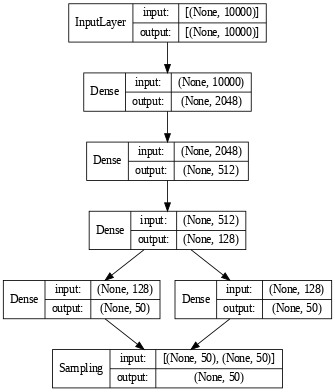

In [ ]:
plot_model(encoder, show_layer_names = False, show_shapes = True, dpi = 60)

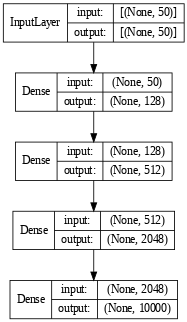

In [ ]:
plot_model(decoder, show_layer_names = False, show_shapes = True, dpi = 60)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    def call(self, inputs):
        _,_,z = self.encoder(inputs)
        return self.decoder(z)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
train_data = (stock_data_vectors['vector'].values).tolist()

In [ ]:
train_data_arr = np.array(train_data)

In [ ]:
# train_data_tensor = tf.convert_to_tensor(train_data_arr, dtype=tf.int64)
train_data_tensor = np.asarray(train_data_arr).astype(np.int)

<ipython-input-56-474d60c863bc>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_data_tensor = np.asarray(train_data_arr).astype(np.int)


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
history = vae.fit(train_data_arr, epochs=15, batch_size=16, shuffle=True)

Epoch 1/15
18/18 [==============================] - 10s 482ms/step - total_loss: 2.3688 - reconstruction_loss: 2.3561 - kl_loss: 0.0126
Epoch 2/15
18/18 [==============================] - 7s 407ms/step - total_loss: 0.2902 - reconstruction_loss: 0.2891 - kl_loss: 0.0011
Epoch 3/15
18/18 [==============================] - 8s 470ms/step - total_loss: 0.1627 - reconstruction_loss: 0.1624 - kl_loss: 3.1357e-04
Epoch 4/15
18/18 [==============================] - 8s 422ms/step - total_loss: 0.1150 - reconstruction_loss: 0.1149 - kl_loss: 1.2704e-04
Epoch 5/15
18/18 [==============================] - 8s 444ms/step - total_loss: 0.1021 - reconstruction_loss: 0.1021 - kl_loss: 2.5087e-05
Epoch 6/15
18/18 [==============================] - 10s 545ms/step - total_loss: 0.1027 - reconstruction_loss: 0.1027 - kl_loss: 3.1177e-06
Epoch 7/15
18/18 [==============================] - 9s 470ms/step - total_loss: 0.0984 - reconstruction_loss: 0.0984 - kl_loss: 1.6838e-06
Epoch 8/15
18/18 [===============

In [ ]:
encoder_outputs = vae.encoder.predict(train_data_arr)

9/9 [==============================] - 1s 48ms/step


In [ ]:
encoded_vectors_text = encoder_outputs[-1].tolist()

In [ ]:
# ///weight calculation for GICS code

mx=[]
mn=[]
for i in range(0,len(encoded_vectors_text)):
  mx.append(sorted(encoded_vectors_text[i])[-1])
  mn.append(sorted(encoded_vectors_text[i])[0])
min_value = sorted(mn)[0]
mx.append(-1*min_value)

max_value = sorted(mx)[-1]
weight = math.ceil(max_value)

weight

5

In [ ]:
# Final vector for a stock
row = []
for i in range(stock_data.shape[0]):
    gics=((stock_data.iloc[i].to_list())[3:])
    weighted_gics = [i * weight for i in gics]
    row.append(encoded_vectors_text[i]+weighted_gics)


[-0.6008366942405701, 0.12076467275619507, -0.22613275051116943, -0.005719597917050123, 0.44614505767822266, 0.583380937576294, -1.285959243774414, -0.24857190251350403, 0.8462004661560059, -0.621603786945343, 1.4168857336044312, 1.3474514484405518, 0.38883233070373535, 0.59824138879776, 0.7558082938194275, -0.38267675042152405, 2.010958433151245, -1.3181111812591553, 0.23296138644218445, 0.27875128388404846, -0.35010188817977905, -0.8344889879226685, 0.6702892780303955, -0.22525815665721893, -1.369577407836914, -0.30191248655319214, 0.4458867907524109, 1.893734335899353, 1.5146777629852295, -0.7685611248016357, -0.12028870731592178, -1.0217978954315186, 0.9466940760612488, -1.8365058898925781, 1.344411849975586, 0.41237008571624756, -0.4366960823535919, 0.5526413321495056, 0.3105345070362091, -0.7126386165618896, -0.2107013612985611, -0.8569956421852112, 1.057524561882019, 0.9740980863571167, 0.4152095317840576, 2.0371718406677246, 0.43126633763313293, -0.5236964225769043, 0.474945038

In [ ]:
size=len(stock_data_vectors.iloc[0].at['encoded_vectors'])

def reshape_vectors(vector):
  arr = np.array(vector).reshape(1,size)
  return arr

In [ ]:
stock_data_vectors['encoded_vectors'] = stock_data_vectors['encoded_vectors'].apply(lambda x : reshape_vectors(x))

In [ ]:
stock_data_vectors['symbol'] = stock_data_vectors['symbol'].apply(lambda x : x.split(".")[0])

In [ ]:

encoded_vectors = row
len(encoded_vectors)

286

In [ ]:
# Calculating Cosine Similarity between Stocks
cos_sim_data = pd.DataFrame(cosine_similarity(encoded_vectors), index = stock_data_vectors['symbol'], columns = stock_data_vectors['symbol'])

In [ ]:
# Generating recommendations using cosine similarity matrix
# stock_business_code: stock symbol, k: number of recommendation, needed to generated, print_recommendation: need to pring recommendations

def give_recommendations(stock_business_code,k,print_recommendation):
  stock_recomm =cos_sim_data.loc[stock_business_code].sort_values(ascending=False).index.tolist()[1:k+1]
  index_recomm = cos_sim_data.loc[stock_business_code].sort_values(ascending=False).values.tolist()[1:k+1]

  result = dict(zip(stock_recomm, index_recomm))

  if print_recommendation==True:
    print('The prefered stock is : {} \n'.format(stock_business_code))
    k = 1
    for stock in stock_recomm:
      print('The number %i recommended stock is this one: %s \n'%(k,stock))
      k = k+1

  return result